# Td3 - ROB 313
## RINCON VIJA Fabian Antonio

### Just to show results

In [1]:
from __future__ import print_function, division

import itertools
import time


import numpy as np
import matplotlib.pyplot as plt

# Colors from Colorbrewer Paired_12
colors = [[31, 120, 180], [51, 160, 44]]
colors = [(r / 255, g / 255, b / 255) for (r, g, b) in colors]

# functions to show an image
def imshow(img):
    """
    :param img: (PyTorch Tensor)
    """
    # unnormalize
    img = img / 2 + 0.5     
    # Convert tensor to numpy array
    npimg = img.numpy()
    # Color channel first -> color channel last
    plt.imshow(np.transpose(npimg, (1, 2, 0)))



def plot_losses(train_history, val_history):
    x = np.arange(1, len(train_history) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(x, train_history, color=colors[0], label="Training loss", linewidth=2)
    plt.plot(x, val_history, color=colors[1], label="Validation loss", linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title("Evolution of the training and validation loss")
    plt.show()

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    :param cm: (numpy matrix) confusion matrix
    :param classes: [str]
    :param normalize: (bool)
    :param title: (str)
    :param cmap: (matplotlib color map)
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.figure(figsize=(8, 8))   
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [2]:
import numpy as np
# Import torch and create the alias "th"
# instead of writing torch.name_of_a_method() , we only need to write th.name_of_a_method()
# (similarly to numpy imported as np)
import torch as th

In [3]:
# Create tensor of ones (FloatTensor by default)
ones = th.ones(3, 2)
print(ones)
print("\n Indexing Demo:")
print(ones[:, 1])
# Create a 3D tensor of size 3x2x2
zeros_3d_tensor = th.zeros(3, 2, 2)
print("Original size:", zeros_3d_tensor.size())

# Reshape it to a 1D array of size 3*2*2 = 12
zeros_1d_array = zeros_3d_tensor.view(3 * 2 * 2)
print("Reshaped tensor:", zeros_1d_array.size())

tensor([[1., 1.],
        [1., 1.],
        [1., 1.]])

 Indexing Demo:
tensor([1., 1., 1.])
Original size: torch.Size([3, 2, 2])
Reshaped tensor: torch.Size([12])


In [4]:
# np.float32 -> th.FloatTensor
ones_matrix = np.ones((2, 2), dtype=np.float32)

# the matrix is passed by reference:
# if we modify the original numpy array, the tensor is also edited
ones_tensor = th.from_numpy(ones_matrix)
# Convert back to a numpy matrix
numpy_matrix = ones_tensor.numpy()

print("PyTorch Tensor:")
print(ones_tensor)

print("Numpy Matrix:")
print(numpy_matrix)

PyTorch Tensor:
tensor([[1., 1.],
        [1., 1.]])
Numpy Matrix:
[[1. 1.]
 [1. 1.]]


# Training an image classifier

## Loading data

In [5]:
import torch
import torchvision
import torchvision.transforms as transforms

In [6]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

if th.cuda.is_available():
  # Make CuDNN Determinist
  th.backends.cudnn.deterministic = True
  th.cuda.manual_seed(seed)

# Define default device, we should use the GPU (cuda) if available
device = th.device("cuda" if th.cuda.is_available() else "cpu")
device

device(type='cuda')

In [7]:
from torch.utils.data.sampler import SubsetRandomSampler

n_training_samples = 20000 # Max: 50 000 - n_val_samples
n_val_samples = 5000
n_test_samples = 5000

train_sampler = SubsetRandomSampler(np.arange(n_training_samples, dtype=np.int64))
val_sampler = SubsetRandomSampler(np.arange(n_training_samples, n_training_samples + n_val_samples, dtype=np.int64))
test_sampler = SubsetRandomSampler(np.arange(n_test_samples, dtype=np.int64))
# (In the last case, indexes do not need to account for training ones because the train=False parameter in datasets.CIF

In [8]:
num_workers = 2
test_batch_size = 4

transform = transforms.Compose(
    [
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=test_batch_size, sampler=train_sampler,
                                          num_workers=num_workers)

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=test_batch_size, sampler=test_sampler,
                                         num_workers=num_workers)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


     horse      horse        dog       deer


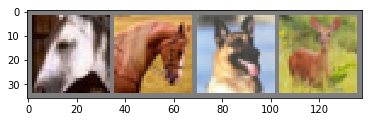

In [9]:
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('{:>10}'.format(classes[labels[j]]) for j in range(test_batch_size)))

## Define a convolution neural network

In [10]:
# Useful imports
import torch.nn as nn
import torch.nn.functional as F

In [11]:
class SimpleConvolutionalNetwork(nn.Module):
    def __init__(self):
        super(SimpleConvolutionalNetwork, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 18, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # cf comments in forward() to have step by step comments
        # on the shape (how we pass from a 3x32x32 input image to a 18x16x16 volume)
        self.fc1 = nn.Linear(18 * 16 * 16, 64) 
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        """
        Forward pass,
        x shape is (batch_size, 3, 32, 32)
        (color channel first)
        in the comments, we omit the batch_size in the shape
        """
        # shape : 3x32x32 -> 18x32x32
        x = F.relu(self.conv1(x))
        # 18x32x32 -> 18x16x16
        x = self.pool(x)
        # 18x16x16 -> 4608
        x = x.view(-1, 18 * 16 * 16)
        # 4608 -> 64
        x = F.relu(self.fc1(x))
        # 64 -> 10
        # The softmax non-linearity is applied later (cf createLossAndOptimizer() fn)
        x = self.fc2(x)
        return x

In [12]:
class LinearClassifier(nn.Module):
    """
    Linear Classifier
    """
    def __init__(self):
        super(LinearClassifier, self).__init__()
        self.linear = nn.Linear(32 * 32 * 3, 10)

    def forward(self, x):
        # Flatten input 3x32x32 -> 3072
        x = x.view(x.size(0), -1)
        return self.linear(x)

In [13]:
import torch.optim as optim

def createLossAndOptimizer(net, learning_rate=0.001):
    # it combines softmax with negative log likelihood loss
    criterion = nn.CrossEntropyLoss()  
    #optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    return criterion, optimizer

### Train the network

In [14]:
def get_train_loader(batch_size):
    return torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=train_sampler,
                                              num_workers=num_workers)

# Use larger batch size for validation to speed up computation
val_loader = torch.utils.data.DataLoader(train_set, batch_size=128, sampler=val_sampler,
                                          num_workers=num_workers)

In [15]:
def train(net, batch_size, n_epochs, learning_rate):
    """
    Train a neural network and print statistics of the training
    
    :param net: (PyTorch Neural Network)
    :param batch_size: (int)
    :param n_epochs: (int)  Number of iterations on the training set
    :param learning_rate: (float) learning rate used by the optimizer
    """
    print("===== HYPERPARAMETERS =====")
    print("batch_size=", batch_size)
    print("n_epochs=", n_epochs)
    print("learning_rate=", learning_rate)
    print("=" * 30)
    
    train_loader = get_train_loader(batch_size)
    n_minibatches = len(train_loader)

    criterion, optimizer = createLossAndOptimizer(net, learning_rate)
    # Init variables used for plotting the loss
    train_history = []
    val_history = []

    training_start_time = time.time()
    best_error = np.inf
    best_model_path = "best_model.pth"
    
    # Move model to gpu if possible
    net = net.to(device)

    for epoch in range(n_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        print_every = n_minibatches // 10
        start_time = time.time()
        total_train_loss = 0
        
        for i, (inputs, labels) in enumerate(train_loader):
            # inputs size is (batch_size,3,32,32)
            # outputs size is (batch_size,10) 
            # labels size is (batch_size)
    
            # Move tensors to correct device
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
#             running_loss += loss.item()
            total_train_loss += loss.item()


        train_history.append(total_train_loss / len(train_loader))

        total_val_loss = 0
        # Do a pass on the validation set
        # We don't need to compute gradient,
        # we save memory and computation using th.no_grad()
        with th.no_grad():
          for inputs, labels in val_loader:
              # Move tensors to correct device
              inputs, labels = inputs.to(device), labels.to(device)
              # Forward pass
              predictions = net(inputs)
              val_loss = criterion(predictions, labels)
              total_val_loss += val_loss.item()
            
        val_history.append(total_val_loss / len(val_loader))
        # Save model that performs best on validation set
        if total_val_loss < best_error:
            best_error = total_val_loss
            th.save(net.state_dict(), best_model_path)

        print("Validation loss = {:.2f}".format(total_val_loss / len(val_loader)))

    print("Training Finished, took {:.2f}s".format(time.time() - training_start_time))
    
    # Load best model
    net.load_state_dict(th.load(best_model_path))
    
    return train_history, val_history

In [16]:
def dataset_accuracy(net, data_loader, name=""):
    net = net.to(device)
    correct = 0
    total = 0
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
    accuracy = 100 * float(correct) / total
    print('Accuracy of the network on the {} {} images: {:.2f} %'.format(total, name, accuracy))
    return accuracy

def train_set_accuracy(net):
    dataset_accuracy(net, train_loader, "train")

def val_set_accuracy(net):
    dataset_accuracy(net, val_loader, "validation")  
    
def test_set_accuracy(net):
    dataset_accuracy(net, test_loader, "test")

def compute_accuracy(net):
    train_set_accuracy(net)
    val_set_accuracy(net)
    test_set_accuracy(net)
    
print("Computing accuracy...")
#compute_accuracy(net)

Computing accuracy...


In [17]:
def accuracy_per_class(net):
    net = net.to(device)
    n_classes = 10
    # (real, predicted)
    confusion_matrix = np.zeros((n_classes, n_classes), dtype=np.int64)

    for images, labels in test_loader:
        images, labels = images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        for i in range(test_batch_size):
            confusion_matrix[labels[i], predicted[i]] += 1
            label = labels[i]

    print("{:<10} {:^10}".format("Class", "Accuracy (%)"))
    for i in range(n_classes):
        class_total = confusion_matrix[i, :].sum()
        class_correct = confusion_matrix[i, i]
        percentage_correct = 100.0 * float(class_correct) / class_total
        
        print('{:<10} {:^10.2f}'.format(classes[i], percentage_correct))
    return confusion_matrix

#confusion_matrix = accuracy_per_class(net)

In [18]:
class MyConvolutionalNetwork(nn.Module):
    def __init__(self):
        super(MyConvolutionalNetwork, self).__init__()
       
        self.conv1 = nn.Conv2d(3, 24, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        #### START CODE: ADD NEW LAYERS ####
        # (do not forget to update `flattened_size`:
        # the input size of the first fully connected layer self.fc1)
        self.conv2 = nn.Conv2d(24, 96, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(96, 384, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(384, 768, kernel_size=3, stride=1, padding=1)
       
        # Size of the output of the last convolution:
        self.flattened_size = 768*8*8
        ### END CODE ###
        
        self.fc1 = nn.Linear(self.flattened_size, 64)
        self.fc2 = nn.Linear(64, 10)
        


    def forward(self, x):
        """
        Forward pass,
        x shape is (batch_size, 3, 32, 32)
        (color channel first)
        in the comments, we omit the batch_size in the shape
        """
        # shape : 3x32x32 -> 24x32x32
        x = F.relu(self.conv1(x))
        # shape : 24x32x32 -> 48x32x32
        x = F.relu(self.conv2(x))
        # 48x32x32 -> 48x16x16
        x = self.pool(x)
        # 48x16X16 -> 96x16x16
        x = F.relu(self.conv3(x))
        # 96x16X16 -> 192x16x16
        x = F.relu(self.conv4(x))
        # 192x16x16 -> 192x8x8
        x = self.pool(x)
        
        #### END CODE ####
        
        # Check the output size
        output_size = np.prod(x.size()[1:])
        assert output_size == self.flattened_size,\
                "self.flattened_size is invalid {} != {}".format(output_size, self.flattened_size)
        
        # 18x16x16 -> 4608
        x = x.view(-1, self.flattened_size)
        # 4608 -> 64
        x = F.relu(self.fc1(x))
        # 64 -> 10
        x = self.fc2(x)
        return x

In [19]:
net = MyConvolutionalNetwork()
train_history, val_history = train(net, batch_size=128, n_epochs=10, learning_rate=0.001)
#plot_losses(train_history, val_history)
accuracy = dataset_accuracy(net, test_loader, "test")

===== HYPERPARAMETERS =====
batch_size= 128
n_epochs= 10
learning_rate= 0.001
Validation loss = 1.33
Validation loss = 1.12
Validation loss = 1.02
Validation loss = 0.92
Validation loss = 0.92
Validation loss = 0.77
Validation loss = 0.77
Validation loss = 0.79
Validation loss = 0.75
Validation loss = 0.81
Training Finished, took 1123.12s
Accuracy of the network on the 5000 test images: 74.42 %


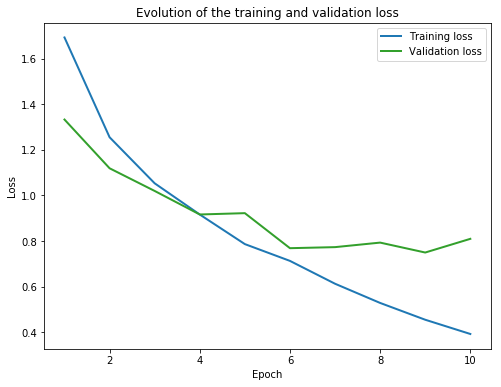

In [20]:
plot_losses(train_history, val_history)

In [21]:
confusion_matrix = accuracy_per_class(net)

Class      Accuracy (%)
plane        79.51   
car          89.50   
bird         76.37   
cat          50.50   
deer         64.30   
dog          63.52   
frog         81.06   
horse        80.40   
ship         78.37   
truck        80.31   


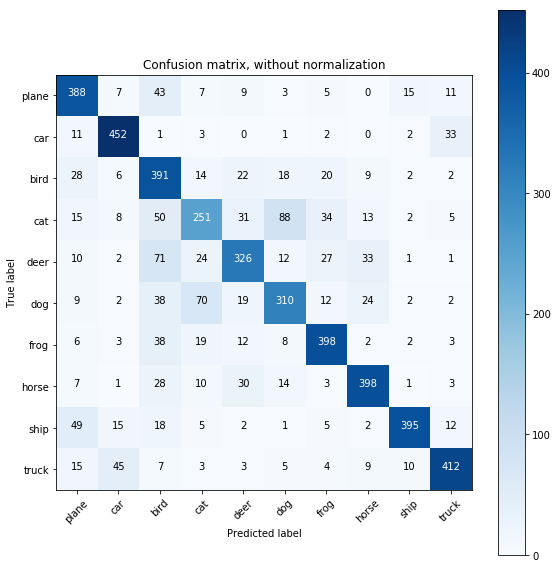

In [22]:
plot_confusion_matrix(confusion_matrix, classes,
                      title='Confusion matrix, without normalization')

In [23]:
compute_accuracy(net)

Accuracy of the network on the 20000 train images: 87.43 %
Accuracy of the network on the 5000 validation images: 74.66 %
Accuracy of the network on the 5000 test images: 74.42 %
